In [1]:
import numpy as np
import tensorflow as tf
from sopt.optimizers.tensorflow2.utils import BackTrackingLineSearch, AdaptiveLineSearch
import matplotlib.pyplot as plt

gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
lossfn = lambda x: tf.reduce_sum((x - 2)**2) 
#@tf.function
def obj_and_upd_fn(x, y): 
    fnval = lossfn(x + y)
    return fnval, x + y

In [3]:
inits = np.random.randn(100).astype('float32') * 20
v1 = tf.Variable(inits)
v2 = tf.Variable(inits)
bls_steps = tf.Variable(0, dtype='int32')
als_steps = tf.Variable(0, dtype='int32')

In [4]:
#@tf.function
def gradfn(v):
    with tf.GradientTape() as gt:
        loss_t = lossfn(v)
    return gt.gradient(loss_t, v)
mean_v = lambda v: tf.reduce_mean(v)

In [5]:
bls = BackTrackingLineSearch()
als = AdaptiveLineSearch()

In [6]:
def update(ls, v, ls_steps):
    grad = gradfn(v)
    ls_out = ls.search(obj_and_upd_fn, v, -grad, grad)
    v.assign(ls_out.newx)
    ls_steps.assign_add(ls_out.step_count)
    return ls_out

In [7]:
print(bls._alpha.numpy())

0.0


In [8]:
#%%time

bls_alphas = []
bls_steps_all = []
bls_lossvals = []
bls_meanvals = []
als_alphas = []
als_steps_all = []
als_lossvals = []
als_meanvals = []
for i in range(10):
    bls_out = update(bls, v1, bls_steps)
    als_out = update(als, v2, als_steps)
    
    bls_steps_all.append(bls_steps.numpy())
    bls_lossvals.append(bls_out.newf.numpy())
    bls_meanvals.append(mean_v(v1).numpy())
    bls_alphas.append(bls._alpha.numpy())
    
    als_steps_all.append(als_steps.numpy())
    als_lossvals.append(als_out.newf.numpy())
    als_meanvals.append(mean_v(v2).numpy())
    als_alphas.append(als._alpha.numpy())

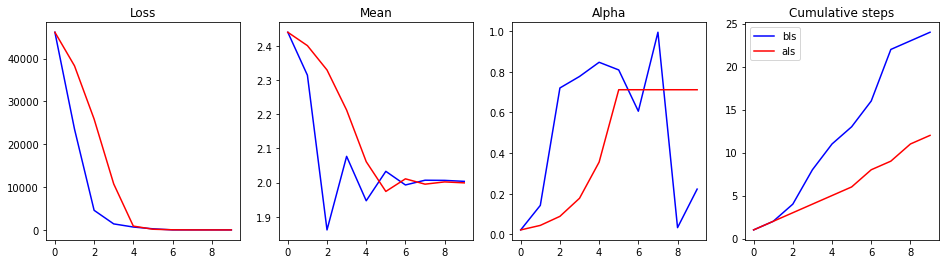

In [9]:
# Final mean should be 2.0

plt.figure(figsize=[16,4])
plt.subplot(1, 4, 1)
plt.plot(bls_lossvals, color='blue')
plt.plot(als_lossvals, color='red')
plt.title('Loss')
plt.subplot(1,4,2)
plt.plot(bls_meanvals, color='blue')
plt.plot(als_meanvals, color='red')
plt.title('Mean')
plt.subplot(1,4,3)
plt.plot(bls_alphas, color='blue')
plt.plot(als_alphas, color='red')
plt.title('Alpha')
plt.subplot(1,4,4)
plt.plot(bls_steps_all, color='blue', label='bls')
plt.plot(als_steps_all, color='red', label='als')
plt.title('Cumulative steps')
plt.legend(loc='best')
plt.show()